In [ ]:
# ==================
# Setup and Imports
# ==================

!pip install transformers datasets accelerate pillow pyarrow torchvision --quiet

import base64
import html
import math
import io
import os
import re


import matplotlib.pyplot as plt
import pandas as pd
import pyarrow.dataset as ds
import pyarrow.parquet as pq
import seaborn as sns
import torch
import torch.nn as nn
from PIL import Image
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, precision_recall_curve, auc
from torch.optim.lr_scheduler import LambdaLR
from torch.utils.data import DataLoader, Dataset, Subset
from torchvision import transforms
from tqdm.auto import tqdm
from transformers import CLIPModel, CLIPProcessor, CLIPFeatureExtractor, CLIPTokenizer

from google.colab import drive




In [ ]:
# ==================================================
# Mount Google Drive and Data Paths to Notebook
# ==================================================

drive.mount('/content/drive', force_remount=True)

DATA_DIR_ROOT = "/content/drive/MyDrive"

TEST_DIR = os.path.join(DATA_DIR_ROOT, "test")
TRAIN_DIR = os.path.join(DATA_DIR_ROOT, "train")
VALIDATION_DIR = os.path.join(DATA_DIR_ROOT, "validate")


Mounted at /content/drive


In [ ]:
#============================
# Dataset Class for Loading
#============================
class NewsCLIPpingsDataset(Dataset):
    def __init__(self, parquet_dir, transform=None, tokenizer=None, max_len=64, cache_images=False):

        self.dataset = ds.dataset(parquet_dir, format="parquet")
        self.table = self.dataset.to_table(columns=["caption", "image", "label"])

        self.captions = self.table["caption"].to_pylist()
        self.images_b64 = self.table["image"].to_pylist()
        self.labels = torch.tensor(self.table["label"].to_numpy(), dtype=torch.float32)

        self.transform = transform
        self.tokenizer = tokenizer
        self.max_len = max_len
        self.cache_images = cache_images

        self._cache = {} if cache_images else None

    def __len__(self):
        return len(self.captions)

    def _decode_image(self, idx):
        if self._cache is not None and idx in self._cache:
            return self._cache[idx]

        img_bytes = base64.b64decode(self.images_b64[idx])
        img = Image.open(io.BytesIO(img_bytes)).convert("RGB")

        if self._cache is not None:
            self._cache[idx] = img
        return img

    def __getitem__(self, idx):
        caption = self.captions[idx]
        image = self._decode_image(idx)
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return {
            "caption": caption,
            "image": image,
            "label": label,
        }


In [ ]:
#===========================
# Datasets and Dataloaders
#===========================

# Collate Function
def collate_fn(batch):
    images = [item["image"] for item in batch]
    captions = [item["caption"] for item in batch]
    labels = torch.tensor([item["label"] for item in batch], dtype=torch.float32)

    return {"image": images, "caption": captions, "label": labels}

#Transforms
train_tf = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(p=0.3),
    transforms.ColorJitter(0.1, 0.1, 0.1, 0.05),
    transforms.RandomGrayscale(p=0.2),

])


# Load Datasets
train_dataset = NewsCLIPpingsDataset(TRAIN_DIR, transform=train_tf)
validation_dataset   = NewsCLIPpingsDataset(VALIDATION_DIR)
test_dataset = NewsCLIPpingsDataset(TEST_DIR)

#Dataloaders
train_loader = DataLoader(
    train_dataset,
    batch_size=128,
    shuffle=True,
    num_workers=8,
    collate_fn=collate_fn,
    pin_memory=True,
    persistent_workers=True,
)

val_loader = DataLoader(
    validation_dataset,
    batch_size=128,
    shuffle=True,
    num_workers=8,
    collate_fn=collate_fn,
    pin_memory=True,
    persistent_workers=True,
)

test_loader = DataLoader(
    test_dataset,
    batch_size=128,
    shuffle=True,
    num_workers=8,
    collate_fn=collate_fn,
    pin_memory=True,
    persistent_workers=True,
)


In [ ]:
#===============================================
# CLIP-Based Binary Classifier Class
#===============================================

class CLIPBinaryClassifier(nn.Module):
    """
    Binary classifier fine-tuned on pretrained CLIP embeddings

    """
    def __init__(self, clip_model, hidden_dim: int = 512):
        """
        Args:
        clip_model: Pretrained CLIP model
        hidden_dim (int): Dimension of CLIP Projection Output
        """

        super().__init__()
        self.clip = clip_model

        #Classification Head
        self.classifier = nn.Sequential(
            nn.Linear(hidden_dim, 256),
            nn.ReLU(),
            nn.Dropout(0.35),
            nn.Linear(256, 1)  #Binary Classifcation
        )

    def forward(self, pixel_values, input_ids, attention_mask):
        """
        Args:
        pixel_values (torch.floatTensor): Preprocessed images from CLIPProcessor
        Shape: (batch_size, 3, 224, 224)

        input_ids (torch.longTensor): Tokenized text sequences from CLIPProcessor
        Shape: (batch_size, seq_len)

        attention_mask (torch.longTensor): Attention masks for text sequences - 0s for padded and 1s for valid
        Shape: (batch_size, seq_len)

        Returns:
        Output logits for binary classification
        Shape: (batch_size, )

        """

        vision_outputs = self.clip.vision_model(pixel_values)
        text_outputs = self.clip.text_model(input_ids=input_ids, attention_mask=attention_mask)

        img_embeds = self.clip.visual_projection(vision_outputs.pooler_output)
        txt_embeds = self.clip.text_projection(text_outputs.pooler_output)

        #Normalize
        img_embeds = img_embeds / img_embeds.norm(dim=-1, keepdim=True)
        txt_embeds = txt_embeds / txt_embeds.norm(dim=-1, keepdim=True)

        # Concatenate or use other fusion methods
        # Option 1: Concatenation
        # fused = torch.cat([img_embeds, txt_embeds], dim=-1)

        # Hadamard Product
        fused = img_embeds * txt_embeds

        logits = self.classifier(fused).squeeze(-1)

        return logits

In [ ]:
#=============================
#Training Helper Functions
#=============================

# Scheduler Function using linear warmup
def scheduler_lr(step):
  warmup_steps = 2500

  if step < warmup_steps:
    return step / warmup_steps

  return 1.0

#Token Dropout Function
def token_dropout(input_ids, attention_mask, dropout_prob=0.1, mask_token_id=None):
    """
    Randomly masks out tokens with dropout_prob.
    Args:
        input_ids (torch.Tensor): Tokenized input IDs of shape [B, seq_len]
        attention_mask (torch.Tensor): Mask for valid tokens
        dropout_prob (float): Probability of masking a token
        mask_token_id (int): Optional token ID to use for masking (defaults to 0 or [MASK])
    """
    if dropout_prob <= 0.0:
        return input_ids
    if mask_token_id is None:
        mask_token_id = 0  # fallback for CLIP

    dropout_mask = (torch.rand(input_ids.shape, device=input_ids.device) < dropout_prob) & (input_ids != mask_token_id)
    dropped = input_ids.masked_fill(dropout_mask, mask_token_id)
    return dropped


# Metrics Helper
def compute_metrics(preds, labels):
    preds = preds.cpu().numpy()
    labels = labels.cpu().numpy()
    acc = accuracy_score(labels, preds)
    prec = precision_score(labels, preds, zero_division=0)
    rec = recall_score(labels, preds, zero_division=0)
    f1 = f1_score(labels, preds, zero_division=0)
    return acc, prec, rec, f1



# Training Step
def train_one_epoch(model, train_loader, processor, criterion, optimizer, scheduler, device, history):
    model.train()
    total_loss = 0
    all_preds, all_labels = [], []

    for batch in tqdm(train_loader,dynamic_ncols=True,leave=False, desc="Training"):
        images, captions, labels = batch["image"], batch["caption"], batch["label"]
        inputs = processor(text=captions, images=images, return_tensors="pt",
                           padding=True, truncation=True).to(device)

        input_ids = token_dropout(inputs["input_ids"], inputs["attention_mask"], dropout_prob=0.1,
                                        mask_token_id=processor.tokenizer.pad_token_id)

        optimizer.zero_grad()
        logits = model(inputs["pixel_values"], input_ids, inputs["attention_mask"])
        loss = criterion(logits, labels.float().to(device))

        loss.backward()
        grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()

        total_loss += loss.item()
        preds = (torch.sigmoid(logits) >= 0.5).int().detach()
        all_preds.append(preds)
        all_labels.append(labels.cpu())

        history["lr"].append(optimizer.param_groups[0]["lr"])
        history["grad_norm"].append(grad_norm.item())

    all_preds = torch.cat(all_preds)
    all_labels = torch.cat(all_labels)

    acc, prec, rec, f1 = compute_metrics(all_preds, all_labels)
    history["train_loss"].append(total_loss / len(train_loader))
    history["train_acc"].append(acc)
    history["train_prec"].append(prec)
    history["train_rec"].append(rec)
    history["train_f1"].append(f1)

    return total_loss / len(train_loader)


# Validation Step
@torch.no_grad()
def validate_one_epoch(model, val_loader, processor, criterion, device, history):
    model.eval()
    total_loss = 0
    all_preds, all_labels, all_probs = [], [], []
    with torch.no_grad():
        for batch in tqdm(val_loader,dynamic_ncols=True,leave=False, desc="Validation"):
            images, captions, labels = batch["image"], batch["caption"], batch["label"]
            inputs = processor(text=captions, images=images, return_tensors="pt",
                              padding=True, truncation=True).to(device)

            logits = model(inputs["pixel_values"], inputs["input_ids"], inputs["attention_mask"])
            loss = criterion(logits, labels.float().to(device))
            total_loss += loss.item()

            preds = (torch.sigmoid(logits) >= 0.5).int()
            all_preds.append(preds.cpu())
            all_labels.append(labels.cpu())
            all_probs.append(torch.sigmoid(logits).cpu())

    all_preds = torch.cat(all_preds)
    all_labels = torch.cat(all_labels)
    all_probs = torch.cat(all_probs)



    history["val_labels"].extend(all_labels.cpu().numpy().tolist())
    history["val_preds"].extend(all_preds.cpu().numpy().tolist())
    history["val_probs"].extend(all_probs.cpu().numpy().tolist())


    acc, prec, rec, f1 = compute_metrics(all_preds, all_labels)

    history["val_loss"].append(total_loss / len(val_loader))
    history["val_acc"].append(acc)
    history["val_prec"].append(prec)
    history["val_rec"].append(rec)
    history["val_f1"].append(f1)

    return total_loss / len(val_loader)


#Test Step
@torch.no_grad()
def test_model(model, test_loader, processor, device, history):
    model.eval()
    all_preds, all_labels, all_probs = [], [], []

    for batch in tqdm(test_loader,dynamic_ncols=True,leave=False, desc="Testing"):
        images, captions, labels = batch["image"], batch["caption"], batch["label"]
        inputs = processor(text=captions, images=images, return_tensors="pt",
                           padding=True, truncation=True).to(device)

        logits = model(inputs["pixel_values"], inputs["input_ids"], inputs["attention_mask"])

        preds = (torch.sigmoid(logits) >= 0.5).int()
        all_preds.append(preds)
        all_labels.append(labels)
        all_probs.append(torch.sigmoid(logits))

    all_preds = torch.cat(all_preds)
    all_labels = torch.cat(all_labels)
    all_probs = torch.cat(all_probs)

    history["test_labels"].extend(all_labels.cpu().numpy().tolist())
    history["test_preds"].extend(all_preds.cpu().numpy().tolist())
    history["test_probs"].extend(all_probs.cpu().numpy().tolist())

    acc, prec, rec, f1 = compute_metrics(all_preds, all_labels)

    print(f"Test Results - Accuracy: {acc:.3f}, Precision: {prec:.3f}, Recall: {rec:.3f}, F1: {f1:.3f}")
    return {"accuracy": acc, "precision": prec, "recall": rec, "f1": f1}



/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

/usr/local/lib/python3.12/dist-packages/transformers/models/clip/feature_extraction_clip.py:30: FutureWarning: The class CLIPFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use CLIPImageProcessor instead.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/605M [00:00<?, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

Loading checkpoint from training_checkpoint.pt.....
2
Loaded checkpointed model, trained on 2 epochs
Epoch 3/7


Train Loss: 0.664, Val Loss: 0.627
Train Accuracy: 0.582, Val Accuracy: 0.641
Epoch 4/7


Train Loss: 0.653, Val Loss: 0.613
Train Accuracy: 0.596, Val Accuracy: 0.652
Epoch 5/7


Train Loss: 0.640, Val Loss: 0.605
Train Accuracy: 0.610, Val Accuracy: 0.658
Epoch 6/7


Train Loss: 0.630, Val Loss: 0.597
Train Accuracy: 0.621, Val Accuracy: 0.667
Epoch 7/7


Train Loss: 0.618, Val Loss: 0.598
Train Accuracy: 0.632, Val Accuracy: 0.669


Test Results - Accuracy: 0.667, Precision: 0.662, Recall: 0.681, F1: 0.671


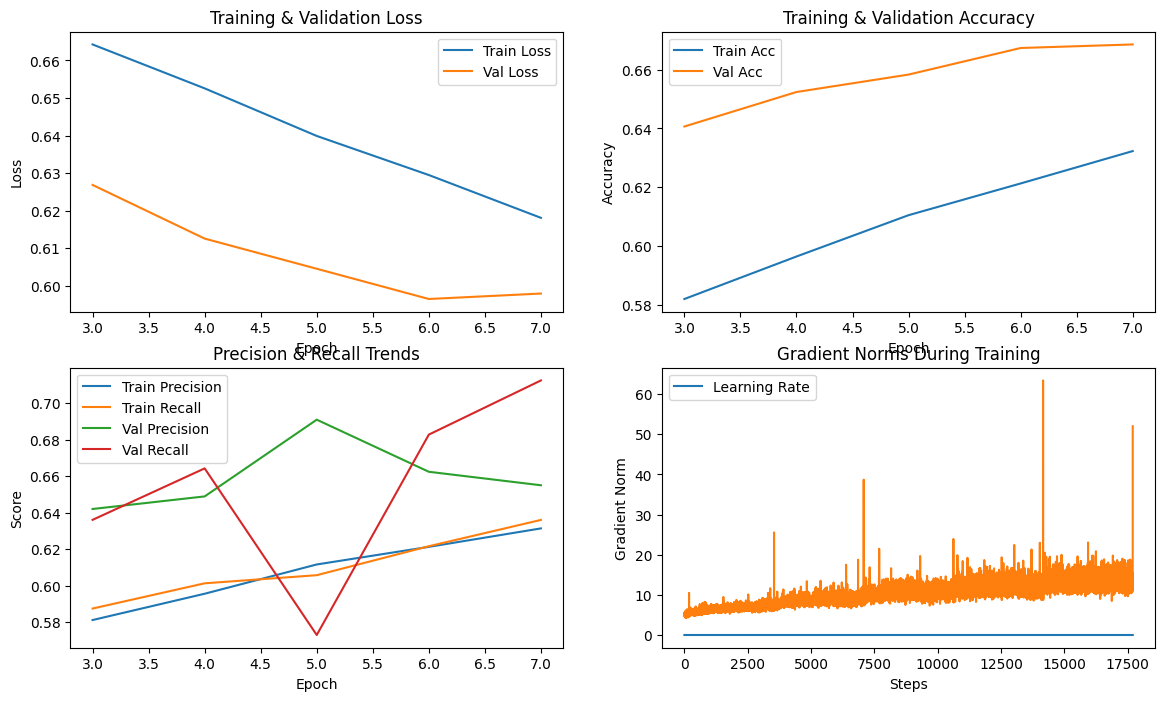

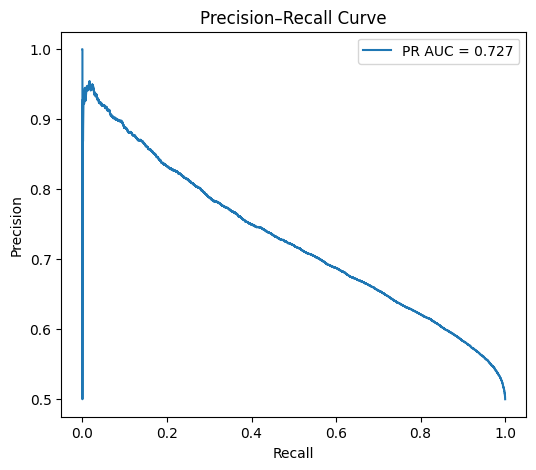

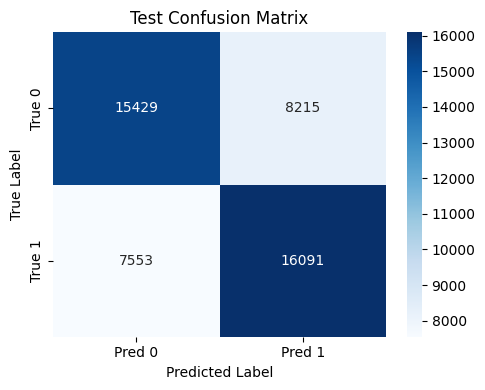

In [ ]:
# ============================================
# Training Setup + Loop
# ============================================

import torch
import torch.nn as nn
import math
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from torch.optim.lr_scheduler import LambdaLR
from tqdm import tqdm
from sklearn.metrics import confusion_matrix


#Training Setup (Models, Optimizers, etc.)

#Load Pretrained CLIP Model + Processor
clip_pretrained_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")

feature_extractor = CLIPFeatureExtractor.from_pretrained("openai/clip-vit-base-patch32")
tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-base-patch32", use_fast=True)

processor = CLIPProcessor(feature_extractor, tokenizer)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#Model Defined by Class
model = CLIPBinaryClassifier(clip_pretrained_model, hidden_dim=512).to(device)

# Loss Fn.
criterion = nn.BCEWithLogitsLoss()

optimizer = torch.optim.AdamW([
    {'params': model.clip.parameters(), 'lr': 1e-6, 'weight_decay': 0.02},
    {'params': model.classifier.parameters(), 'lr': 5e-4, 'weight_decay': 0.01}
])

#Scheduler
scheduler = LambdaLR(optimizer, scheduler_lr)

#Track Epoch stats to visualize
history = {
    "train_loss": [],
    "val_loss": [],
    "train_acc": [],
    "val_acc": [],
    "train_prec": [],
    "val_prec": [],
    "train_rec": [],
    "val_rec": [],
    "train_f1": [],
    "val_f1": [],
    "lr": [],
    "grad_norm": [],
    "val_labels": [],
    "val_preds": [],
    "val_probs": [],
    "test_labels": [],
    "test_preds": [],
    "test_probs": [],
}


# Checkpoint Loading
start_epoch = 0
best_val_loss = float('inf')
checkpoint_path = "training_checkpoint.pt" #Path of Checkpoint

if os.path.exists(checkpoint_path):
    print(f"Loading checkpoint from {checkpoint_path}.....")

    checkpoint = torch.load(checkpoint_path, map_location=device)

    model.load_state_dict(checkpoint["model_state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
    scheduler.load_state_dict(checkpoint["scheduler_state_dict"])
    best_val_loss = checkpoint.get("best_val_loss", float('inf'))
    start_epoch = checkpoint.get("epoch", 0)
    print(start_epoch)
    print(f"Loaded checkpointed model, trained on {start_epoch} epochs")

else:
  print("No checkpoint found. Training from scratch......")


#Training Loop
EPOCHS = 7 #Total epochs you want to train

for epoch in range(start_epoch, EPOCHS):
    print(f"Epoch {epoch+1}/{EPOCHS}")
    train_loss = train_one_epoch(model, train_loader, processor, criterion, optimizer, scheduler, device, history)
    val_loss = validate_one_epoch(model, val_loader, processor, criterion, device, history)

    train_acc = history["train_acc"][-1]
    val_acc = history["val_acc"][-1]

    print(f"Train Loss: {train_loss:.3f}, Val Loss: {val_loss:.3f}")

    print(f"Train Accuracy: {train_acc:.3f}, Val Accuracy: {val_acc:.3f}")
    #Save Best Model's Parameters
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), "best_model.pt")


#Save final checkpoint for future training
checkpoint = {
    "epoch": EPOCHS,
    "model_state_dict": model.state_dict(),
    "optimizer_state_dict": optimizer.state_dict(),
    "scheduler_state_dict": scheduler.state_dict(),
    "best_val_loss": best_val_loss,
}

torch.save(checkpoint, "training_checkpoint.pt")

#Visualization

epochs = range(start_epoch + 1, EPOCHS + 1)

#Train and Validation Loss vs. Epochs
plt.figure(figsize=(14, 8))
plt.subplot(2, 2, 1)
plt.plot(epochs, history["train_loss"], label="Train Loss")
plt.plot(epochs, history["val_loss"], label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training & Validation Loss")
plt.legend()

#Train and Validation Acc. vs. Epochs
plt.subplot(2, 2, 2)
plt.plot(epochs, history["train_acc"], label="Train Acc")
plt.plot(epochs, history["val_acc"], label="Val Acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training & Validation Accuracy")
plt.legend()

# Precision and Recall Trends
plt.subplot(2, 2, 3)
plt.plot(epochs, history["train_prec"], label="Train Precision")
plt.plot(epochs, history["train_rec"], label="Train Recall")
plt.plot(epochs, history["val_prec"], label="Val Precision")
plt.plot(epochs, history["val_rec"], label="Val Recall")
plt.xlabel("Epoch")
plt.ylabel("Score")
plt.title("Precision & Recall Trends")
plt.legend()


#Learning Rate through Training
plt.subplot(2, 2, 4)
plt.plot(history["lr"], label="Learning Rate")
plt.xlabel("Steps")
plt.ylabel("LR")
plt.title("Learning Rate Schedule")
plt.legend()

#Gradient Norm Curve
plt.plot(history["grad_norm"])
plt.title("Gradient Norms During Training")
plt.xlabel("Steps")
plt.ylabel("Gradient Norm")


# Load best model and evaluate
model.load_state_dict(torch.load("best_model.pt"))
test_model(model, test_loader, processor, device, history)

# Test-set Precision-Recall Curve

precision, recall, thresholds = precision_recall_curve(history["test_labels"], history["test_probs"])
pr_auc = auc(recall, precision)

plt.figure(figsize=(6,5))
plt.plot(recall, precision, label=f"PR AUC = {pr_auc:.3f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve")
plt.legend()


# Test-set Confusion Matrix

cm = confusion_matrix(history["test_labels"], history["test_preds"])
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Pred 0", "Pred 1"],
            yticklabels=["True 0", "True 1"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Test Confusion Matrix")


plt.tight_layout()
plt.show()

